In [1]:
import pandas as pd
import numpy as np
from arcgis.features import GeoAccessor, GeoSeriesAccessor
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv?raw=true')
df = df.fillna(value={'fips': -1})
df = df.astype({'fips': 'int64'})
sdf = pd.DataFrame.spatial.from_featureclass(r"G:\courses\qmsa\Chapter15\Chapter15.gdb\USA_Counties_COVID")
df

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0
...,...,...,...,...,...,...
98257,2020-04-28,Sublette,Wyoming,56035,1,0
98258,2020-04-28,Sweetwater,Wyoming,56037,10,0
98259,2020-04-28,Teton,Wyoming,56039,65,1
98260,2020-04-28,Uinta,Wyoming,56041,6,0


In [19]:
df = df.loc[df.state=='Mississippi']
sdf = sdf.loc[sdf.State=='Mississippi']

In [28]:
#df['fips'] = np.where((df.county == 'Unknown'),-1,df.fips)

datelist=df['date'].unique().tolist()
datelist = datelist[10:]
datelist

['2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-05',
 '2020-04-06',
 '2020-04-07',
 '2020-04-08',
 '2020-04-09',
 '2020-04-10',
 '2020-04-11',
 '2020-04-12',
 '2020-04-13',
 '2020-04-14',
 '2020-04-15',
 '2020-04-16',
 '2020-04-17',
 '2020-04-18',
 '2020-04-19',
 '2020-04-20',
 '2020-04-21',
 '2020-04-22',
 '2020-04-23',
 '2020-04-24',
 '2020-04-25',
 '2020-04-26',
 '2020-04-27',
 '2020-04-28']

In [29]:
import arcpy
moransIList = []
biglist = []
for idate in datelist:
    dateDF = df.loc[df.date==idate]
    print(idate)

    joinedDate = sdf.set_index('FIPSm').join(dateDF.set_index('fips')).fillna(value={'cases': 0, 'deaths': 0})
    outputLOC = r"G:\courses\qmsa\Chapter15\Chapter15.gdb\USA_Counties_COVID_" + str(idate).replace("-","_")
    #print(outputLOC)
    joinedDate["casesPerThousand"] = joinedDate["cases"] /  (joinedDate["Population"] / 1000)
    joinedDate["deathsPer100k"] = joinedDate["deaths"] /  (joinedDate["Population"] / 100000)
    joinedDate["date"] = idate
    joinedDate = joinedDate.fillna(value={'county': "", "state": ""})
    joinedDate.spatial.to_featureclass(location=outputLOC)
    moransI = arcpy.SpatialAutocorrelation_stats(outputLOC, "deathsPer100k","NO_REPORT","INVERSE_DISTANCE_SQUARED","EUCLIDEAN DISTANCE", "ROW")
    moransIList.append(moransI)
    print(moransI, joinedDate["deaths"].sum(), joinedDate["cases"].sum())
    biglist.append((moransI, joinedDate["deaths"].sum(), joinedDate["cases"].sum()))

2020-03-21
-0.017401 1.0 140.0
2020-03-22
-0.017401 1.0 207.0
2020-03-23
-0.017401 1.0 249.0
2020-03-24
-0.017401 1.0 320.0
2020-03-25
-0.033258 5.0 377.0
2020-03-26
-0.034816 6.0 487.0
2020-03-27
-0.044009 8.0 576.0
2020-03-28
-0.078403 13.0 663.0
2020-03-29
-0.060108 14.0 759.0
2020-03-30
-0.056889 16.0 848.0
2020-03-31
-0.014333 20.0 937.0
2020-04-01
0.023602 22.0 1073.0
2020-04-02
-0.017053 26.0 1177.0
2020-04-03
-0.027691 29.0 1358.0
2020-04-04
-0.043184 35.0 1455.0
2020-04-05
-0.005436 43.0 1638.0
2020-04-06
0.005374 51.0 1738.0
2020-04-07
0.021306 59.0 1915.0
2020-04-08
0.003867 67.0 2003.0
2020-04-09
0.027232 76.0 2260.0
2020-04-10
0.012005 82.0 2469.0
2020-04-11
0.027847 93.0 2642.0
2020-04-12
0.024918 96.0 2781.0
2020-04-13
0.005466 98.0 2942.0
2020-04-14
0.026283 111.0 3087.0
2020-04-15
0.108774 122.0 3360.0
2020-04-16
0.161532 129.0 3624.0
2020-04-17
0.182194 140.0 3793.0
2020-04-18
0.200907 152.0 3974.0
2020-04-19
0.189634 159.0 4274.0
2020-04-20
0.172933 169.0 4512.0
2020

In [30]:
c = 0
newlist = []
for item in biglist:
    newlist.append((datelist[c], float(item[0][0]), int(item[1]), int(item[2])))
    #float(item[0][1]), float(item[0][2])
    c=c+1


df = pd.DataFrame(newlist, columns =['date', 'I', 'deaths', 'cases']) 
#df['rolling'] = df['I'].rolling(window=3)
df = df.set_index('date')
df['deaths_n'] = df['deaths'] / df['deaths'].max()
df['cases_n'] = df['cases'] / df['cases'].max()

a=df[['I', 'deaths_n', 'cases_n']].rolling(5,center=True, min_periods=1).mean()
b=df[['I', 'deaths', 'cases']].rolling(5,center=True, min_periods=1).mean()

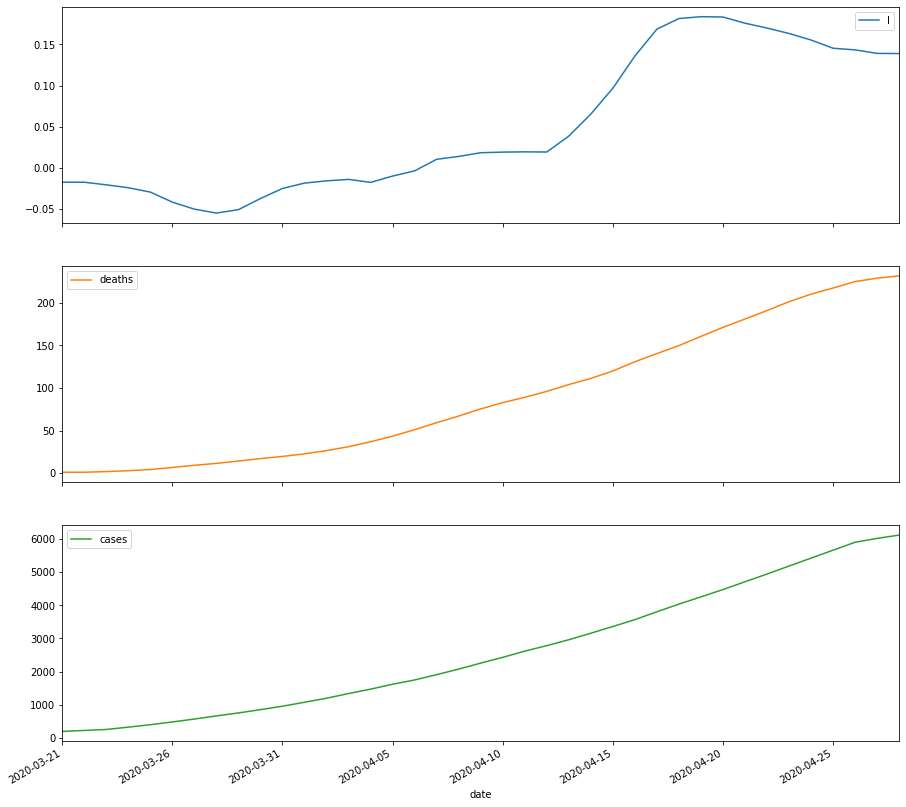

In [31]:
import matplotlib.pyplot as plt
axes = b.plot.line(subplots=True, figsize=(15,15))

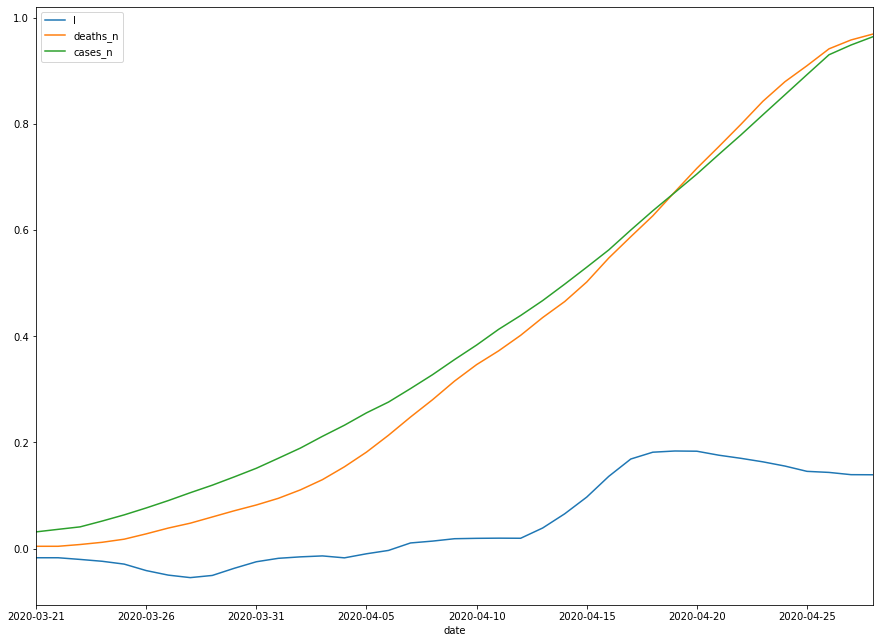

In [32]:
axes = a.plot.line(subplots=False, figsize=(15,11))